<a href="https://colab.research.google.com/github/rawanalrfaie524/sales-predictions-model/blob/main/sales_predictions_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # This line imports mean_squared_error correctly
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# The following line was incorrect and has been removed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler # Fixed typo: 'prepricessing' to 'preprocessing'
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Fixed typo: 'Modelcheckpoint' to 'ModelCheckpoint'

In [7]:
sales = pd.read_csv('/content/train.csv', encoding='latin1')
# or 'ISO-8859-1' or 'cp1252', depending on your file's actual encoding
sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


to check for null value into dataset

In [8]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    57967 non-null  object
 1   store   57967 non-null  int64 
 2   item    57967 non-null  int64 
 3   sales   57967 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


In [9]:
print(sales.columns)

Index(['date', 'store', 'item', 'sales'], dtype='object')


converting date from object Datatype to data time datatype

In [11]:
sales['date'] = pd.to_datetime(sales['date'])
sales['date'] = pd.to_datetime(sales['date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57967 entries, 0 to 57966
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    57967 non-null  datetime64[ns]
 1   store   57967 non-null  int64         
 2   item    57967 non-null  int64         
 3   sales   57967 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.8 MB


converting date to month period, and then sum the number of item in each month

---



In [18]:
# Assuming apico_sales['Invoice Date'] is already a datetime column from a previous cell
# Check if the column is already a Period object
if not hasattr(sales['date'].dtype, 'freq'): # Check for freq attribute which indicates PeriodDtype
    # Ensure 'Invoice Date' is datetime before using .dt accessor
    sales['date'] = pd.to_datetime(sales['date'])  # Convert to datetime if not already
    sales['date'] = sales['date'].dt.to_period("M") # Convert to period only if not already a Period
monthly_sales = sales.groupby('date')['sales'].sum().reset_index()

In [ ]:
monthly_sales.head(23)

,Invoice \nDate,Value
0,2023-01,11913214.13
1,2023-02,11920663.47
2,2023-03,11215817.83
3,2023-04,10692779.11
4,2023-05,12295993.48
5,2023-06,12050861.28
6,2023-07,9485576.56
7,2023-08,10475785.39
8,2023-09,12067471.66
9,2023-10,10673147.60


*Visualization*

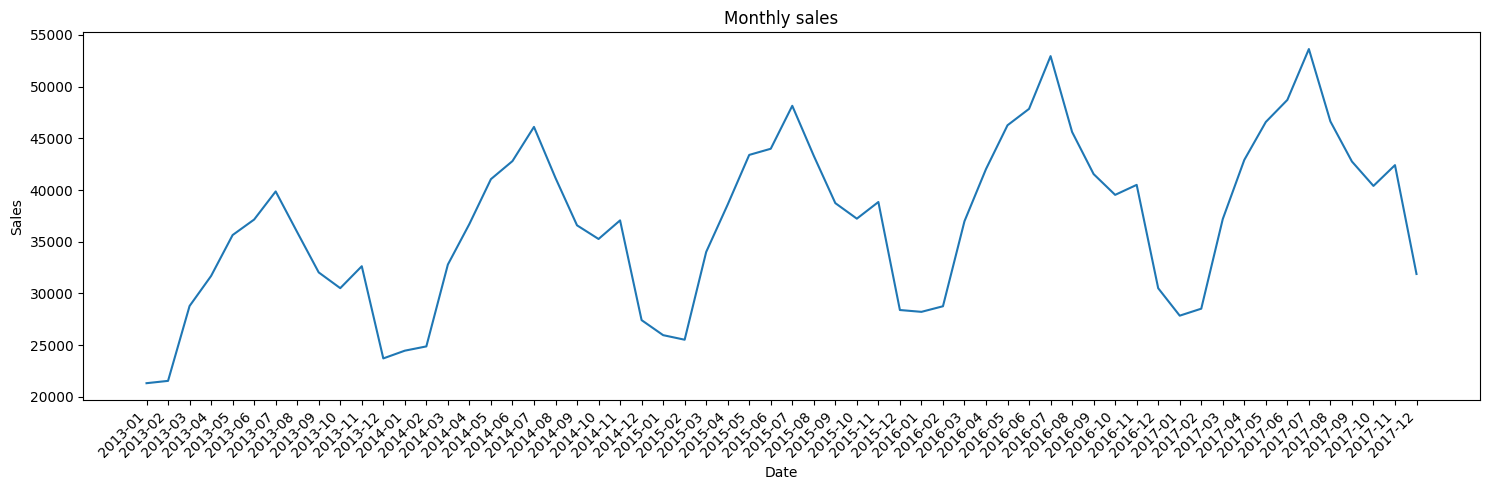

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'].astype(str), monthly_sales['sales'])  # Convert to string
plt.title('Monthly sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

call the difference on the sales columns to make the sales data stationery

In [20]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02,21556,224.0
2,2013-03,28791,7235.0
3,2013-04,31696,2905.0
4,2013-05,35647,3951.0
5,2013-06,37147,1500.0
6,2013-07,39860,2713.0
7,2013-08,35927,-3933.0
8,2013-09,32035,-3892.0
9,2013-10,30515,-1520.0
10,2013-11,32634,2119.0


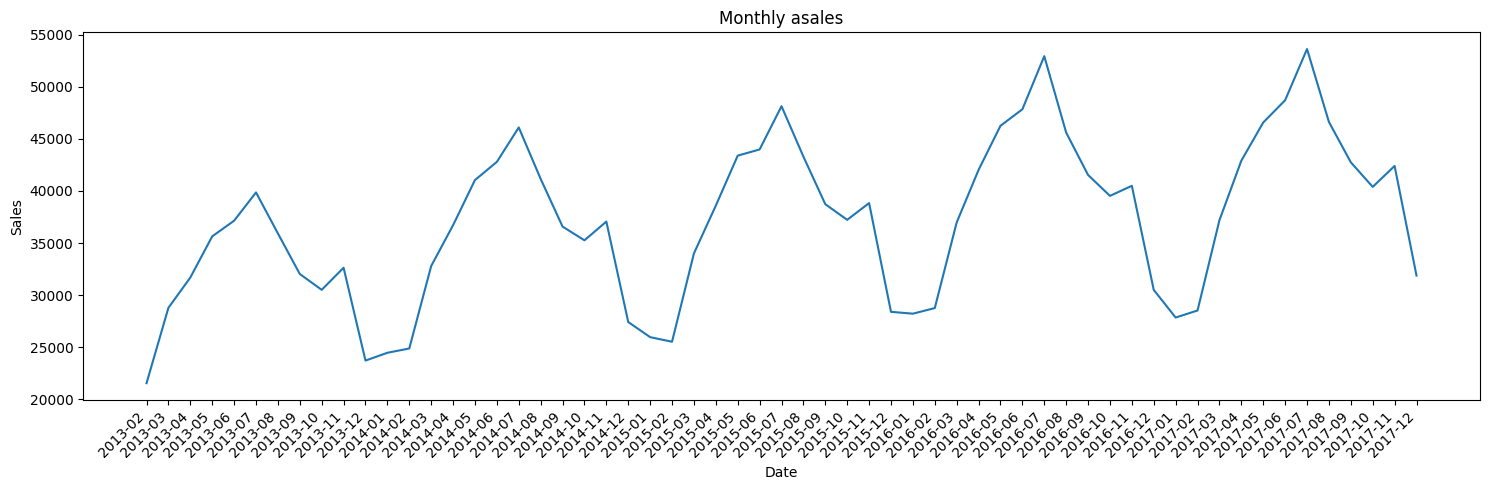

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'].astype(str), monthly_sales['sales'])  # Convert to string
plt.title('Monthly asales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

preparing the Supervised data set - to make Predict sales for next month

In [23]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

preparing supervised Data

In [24]:
for i in range(1,13):
    col_name="month_"+str(i)
    supervised_data[col_name]=supervised_data["sales_diff"].shift(i)
# The following line was incorrectly indented
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0,224.0
1,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0,7235.0
2,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0,2905.0
3,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0,3951.0
4,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0,1500.0
5,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0,2713.0
6,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0,-3933.0
7,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0,-3892.0
8,-1319.0,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0,-1520.0
9,1797.0,-1319.0,-4575.0,-4936.0,3304.0,1744.0,4330.0,3922.0,7910.0,413.0,748.0,-8908.0,2119.0


split data into Train and Test

In [25]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:] # Removed the unexpected indentation
print("Train data shape",train_data.shape)
print("Test data shape",test_data.shape)

Train data shape (35, 13)
Test data shape (12, 13)


In [26]:
# Assuming supervised_data is your DataFrame
if len(supervised_data) > 12:
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]
else:
    # Handle the case where there's not enough data for splitting
    # For example, you could use a smaller test set size
    train_data = supervised_data[:-6]  # Use only the last 6 months for testing
    test_data = supervised_data[-6:]
    # Or raise an error and ask the user to provide more data
    # raise ValueError("Not enough data for training and testing. Please provide more data.")

print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

Train data shape (35, 13)
Test data shape (12, 13)


In [27]:
x_train = train_data.iloc[:, 1:].values # Use .iloc for integer-based indexing
y_train = train_data.iloc[:, 0].values # Select the first column (index 0) as the target variable
x_test = test_data.iloc[:, 1:].values   # Use .iloc for integer-based indexing
y_test = test_data.iloc[:, 0].values   # Select the first column (index 0) as the target variable

y_train = y_train.ravel() # Convert y_train to a 1D array
y_test = y_test.ravel()   # Convert y_test to a 1D array

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (35, 12)
y_train shape: (35,)
x_test shape: (12, 12)
y_test shape: (12,)


make prediction data frame to merge the predicted sales prices of all trained algorithms

In [28]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [29]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[30509, 27857, 28532, 37194, 42907, 46574, 48706, 53621, 46627, 42754, 40395, 42403, 31884]


to craete the linear regression model, and predicted output

In [33]:
# prompt: to craete the linear regression model, and predicted output

# Create and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Make predictions on the test set
lr_predict = lr_model.predict(x_test)

# Evaluate the model
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predict))
lr_mae = mean_absolute_error(y_test, lr_predict)
lr_r2 = r2_score(y_test, lr_predict)

print(f"Linear Regression - RMSE: {lr_rmse}, MAE: {lr_mae}, R-squared: {lr_r2}")

# Add the predictions to the prediction DataFrame
predict_df['LR_predict'] = lr_predict

Linear Regression - RMSE: 951.3980891340792, MAE: 713.9996532031282, R-squared: 0.9681760199249727


In [34]:
# Previous code...

# Check if supervised_data has enough rows for splitting
if len(supervised_data) > 12:
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]
else:
    # Handle the case where there's not enough data for splitting
    # For example, you could use a smaller test set size
    train_data = supervised_data[:-6]  # Use only the last 6 months for testing
    test_data = supervised_data[-6:]
    # Or raise an error and ask the user to provide more data
    # raise ValueError("Not enough data for training and testing. Please provide more data.")

print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)


# Continue with the rest of your code...

Train data shape (35, 13)
Test data shape (12, 13)


In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ... (Your previous code for loading and preparing 'monthly_sales' DataFrame) ...

supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

for i in range(1, 13):
    col_name = "month_" + str(i)
    supervised_data[col_name] = supervised_data["sales_diff"].shift(i)

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

# Check if supervised_data has enough rows for splitting
if len(supervised_data) > 12:
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]
else:
    # Handle the case where there's not enough data for splitting
    # For example, you could use a smaller test set size or raise an error
    train_data = supervised_data[:-6]  # Use only the last 6 months for testing
    test_data = supervised_data[-6:]
    # Or raise an error:
    # raise ValueError("Not enough data for training and testing. Please provide more data.")

print("Train data shape", train_data.shape)
print("Test data shape", test_data.shape)

# Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)  # Fit the scaler on the training data only
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Convert scaled data back to DataFrames
train_data = pd.DataFrame(train_data, columns=supervised_data.columns)
test_data = pd.DataFrame(test_data, columns=supervised_data.columns)

# Feature and target selection
x_train = train_data.drop('sales_diff', axis=1)
y_train = train_data['sales_diff']
x_test = test_data.drop('sales_diff', axis=1)
y_test = test_data['sales_diff']

y_train = y_train.ravel()
y_test = y_test.ravel()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# ... (The rest of your code for model training and evaluation) ...

Train data shape (35, 13)
Test data shape (12, 13)
x_train shape: (35, 12)
y_train shape: (35,)
x_test shape: (12, 12)
y_test shape: (12,)


<ipython-input-36-660bfb81e9e2>:46: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train = y_train.ravel()
<ipython-input-36-660bfb81e9e2>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_test = y_test.ravel()


In [38]:
#prediction dataframe to mereg predicted sales price of all tranied algo
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)
act_sales=monthly_sales['sales'][-13:].to_list()

In [39]:
from sklearn.ensemble import RandomForestRegressor

lr_model = RandomForestRegressor(
    n_estimators=30,
    min_samples_split=14,
    min_samples_leaf=1,
    max_features=0.5,
    max_depth=3,
    random_state=42
)

In [40]:
lr_model.fit(x_train,y_train)
lr_pre= lr_model.predict(x_test)
lr_pre=lr_pre.reshape(-1,1)#created lr prediction
lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)#matrix with input features of test data and predicted output
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [41]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series=pd.Series(result_list,name="Linear Prediction")
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

print("hallo",predict_df["Linear Prediction"])

hallo 0     30976.397603
1     28591.405595
2     33237.141171
3     41899.141171
4     47267.342825
5     47667.973929
6     53244.050695
7     48089.681230
8     41095.681230
9     40505.228713
10    40962.315119
11    36277.568190
Name: Linear Prediction, dtype: float64


In [47]:
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])
lr_r2 = r2_score(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])


print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2)

Linear Regression MSE: 2128.9202481331254
Linear Regression MAE: 1609.7767366816345
Linear Regression R2: 0.9125033500272711


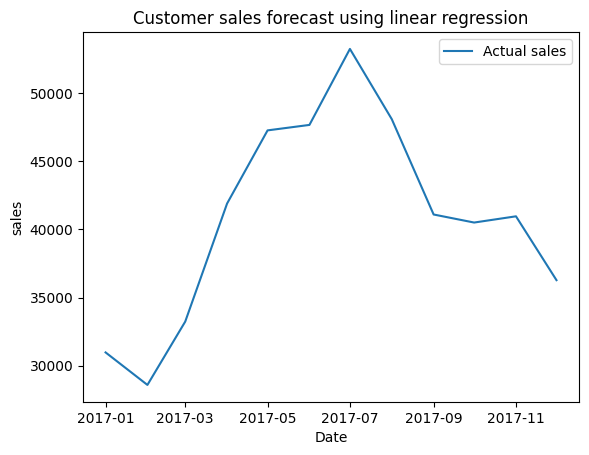

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Invoice \nDate' column is of Period type
# Convert 'Invoice \nDate' to timestamps for plotting
predict_df['date'] = predict_df['date'].dt.to_timestamp()

# Now you can plot the data
plt.plot(predict_df["date"], predict_df["Linear Prediction"])
plt.title("Customer sales forecast using linear regression")
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(["Actual sales", "Predicted sales"])
plt.show()

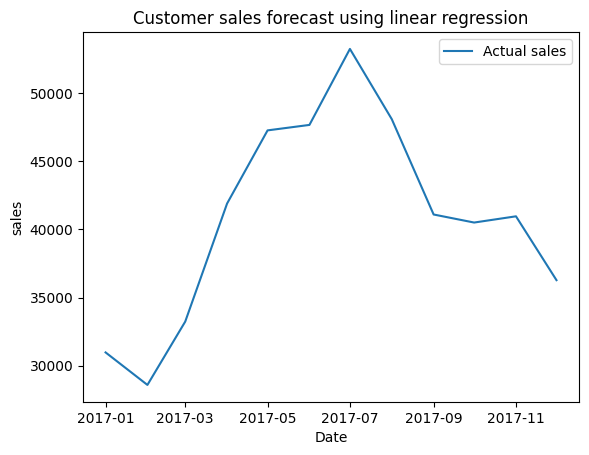

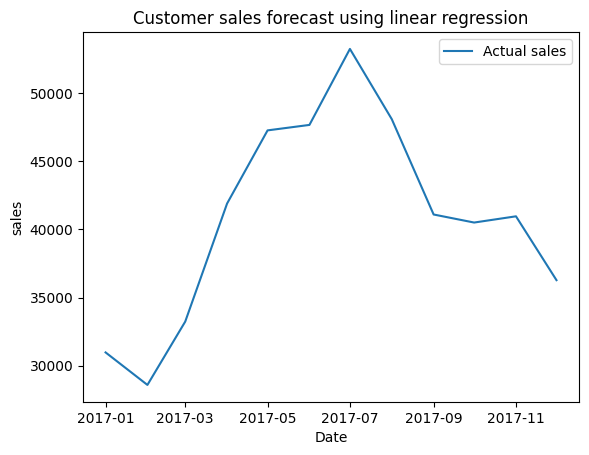

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Invoice \nDate' column is of Period type
# Convert 'Invoice \nDate' to timestamps for plotting
# predict_df['Invoice \nDate'] = predict_df['Invoice \nDate'].dt.to_timestamp() # Remove or comment this line

# Check if 'Invoice \nDate' is already datetime-like
if not pd.api.types.is_datetime64_any_dtype(predict_df['date']):
    # If not, try to convert it
    predict_df['date'] = pd.to_datetime(predict_df['sales'])

# Now you can plot the data
plt.plot(predict_df["date"], predict_df["Linear Prediction"])
plt.title("Customer sales forecast using linear regression")
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(["Actual sales", "Predicted sales"])
plt.show()

# ... (Rest of your code remains the same) ...
# Now you can plot the data
plt.plot(predict_df["date"], predict_df["Linear Prediction"])
plt.title("Customer sales forecast using linear regression")
plt.xlabel("Date")
plt.ylabel("sales")
plt.legend(["Actual sales", "Predicted sales"])
plt.show()

# Add this in the cell for 'ipython-input-77-b8514f6b4450'
# before line 1 to provide context

# Define ids_to_predict before the loop
# Replace this with your actual list of ids
ids_to_predict = [1, 2, 3, 4, 5, 6]  # Example list of IDs

# Create an empty DataFrame to store the results
df_rest_of_year = pd.DataFrame(columns=['id', 'januar', 'Febuary', 'March', 'April', 'Mai', 'June', 'july', 'August', 'September', 'October', 'November', 'December'])

for say,value in enumerate(ids_to_predict):
    # Ensure column_list only has 12 elements, or fewer if predict_df has less
    column_list = predict_df['Linear Prediction'].tolist()
    # Pad column_list with None if it has fewer than 12 elements
    column_list += [None] * (12 - len(column_list))
    #Define new_row within loop
    new_row = {'id': value, 'januar':column_list[0],'Febuary':column_list[1],'March':column_list[2],'April':column_list[3],'Mai':column_list[4],'June':column_list[5],'july':column_list[6],'August':column_list[7],'September':column_list[8],'October':column_list[9],'November':column_list[10],'December':column_list[11] }
    df_rest_of_year.loc[say]=new_row

In [52]:
# original code from ipython-input-82-0654b0bbd9d8 and ipython-input-83-0654b0bbd9d8

import pandas as pd
import matplotlib.pyplot as plt

# ... (Rest of the code from ipython-input-82-0654b0bbd9d8)

# Define ids_to_predict before the loop
# Replace this with your actual list of ids
ids_to_predict = [1, 2, 3, 4, 5, 6]  # Example list of IDs

# Create an empty DataFrame to store the results
df_rest_of_year = pd.DataFrame(columns=['id', 'januar', 'Febuary', 'March', 'April', 'Mai', 'June', 'july', 'August', 'September', 'October', 'November', 'December'])

for say,value in enumerate(ids_to_predict):
    # Ensure column_list only has 12 elements, or fewer if predict_df has less
    column_list = predict_df['Linear Prediction'].tolist()
    # Pad column_list with None if it has fewer than 12 elements
    column_list += [None] * (12 - len(column_list))
    #Define new_row within loop
    new_row = {'id': value, 'januar':column_list[0],'Febuary':column_list[1],'March':column_list[2],'April':column_list[3],'Mai':column_list[4],'June':column_list[5],'july':column_list[6],'August':column_list[7],'September':column_list[8],'October':column_list[9],'November':column_list[10],'December':column_list[11] }
    df_rest_of_year.loc[say]=new_row

    # The print statement was indented, causing the error.
    # It should be at the same level as the 'for' statement if intended to be outside the loop.
    # Or keep it indented if it should print within the loop.
    print(say)  # If you want to print inside the loop


# Move this part out of the loop if you want the final count
# say = say + 1
# print(say) # If you want to print the final count after the loop

df_rest_of_year.to_csv("June_predictions_2025",index=False)
df_rest_of_year.to_excel("june_predictions_2025.xlsx") # Add .xlsx extension for Excel file

0
1
2
3
4
5
